In [102]:
amazon = [line.rstrip() for line in open('./sentiment labelled sentences/amazon_cells_labelled.txt', encoding="utf-8")]
imdb = [line.rstrip() for line in open('./sentiment labelled sentences/imdb_labelled.txt', encoding="utf-8")]
yelp = [line.rstrip() for line in open('./sentiment labelled sentences/yelp_labelled.txt', encoding="utf-8")]
text = []
category = []
label = []

for i in amazon:
    content = i.split('\t')
    text.append(content[0])
    category.append('amazon')
    label.append(content[1])
    
for i in imdb:
    content = i.split('\t')
    text.append(content[0])
    category.append('imdb')
    label.append(content[1])
for i in yelp:
    content = i.split('\t')
    text.append(content[0])
    category.append('yelp')
    label.append(content[1])


In [103]:
import pandas as pd
X = pd.DataFrame({'text': text, 'category_name': category,'label': label})

In [104]:
import nltk
import helpers.data_mining_helpers as dmh
# takes a like a minute or two to process
X['unigrams'] = X['text'].apply(lambda x: dmh.tokenize_text(x))

## CountVectorizer

In [105]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(X.text) #learn the vocabulary and return document-term matrix
print(X_counts[0])

  (0, 4161)	1
  (0, 4545)	1
  (0, 2427)	1
  (0, 3043)	1
  (0, 4987)	1
  (0, 1829)	1
  (0, 2809)	1
  (0, 4609)	1
  (0, 3387)	1
  (0, 2432)	1
  (0, 2314)	2
  (0, 2158)	1
  (0, 4531)	1
  (0, 4835)	1
  (0, 4793)	1
  (0, 1982)	1
  (0, 647)	1
  (0, 1013)	1


In [106]:
from sklearn.decomposition import PCA
X_reduced = PCA(n_components = 2).fit_transform(X_counts.toarray())
categories = ['amazon', 'imdb', 'yelp']

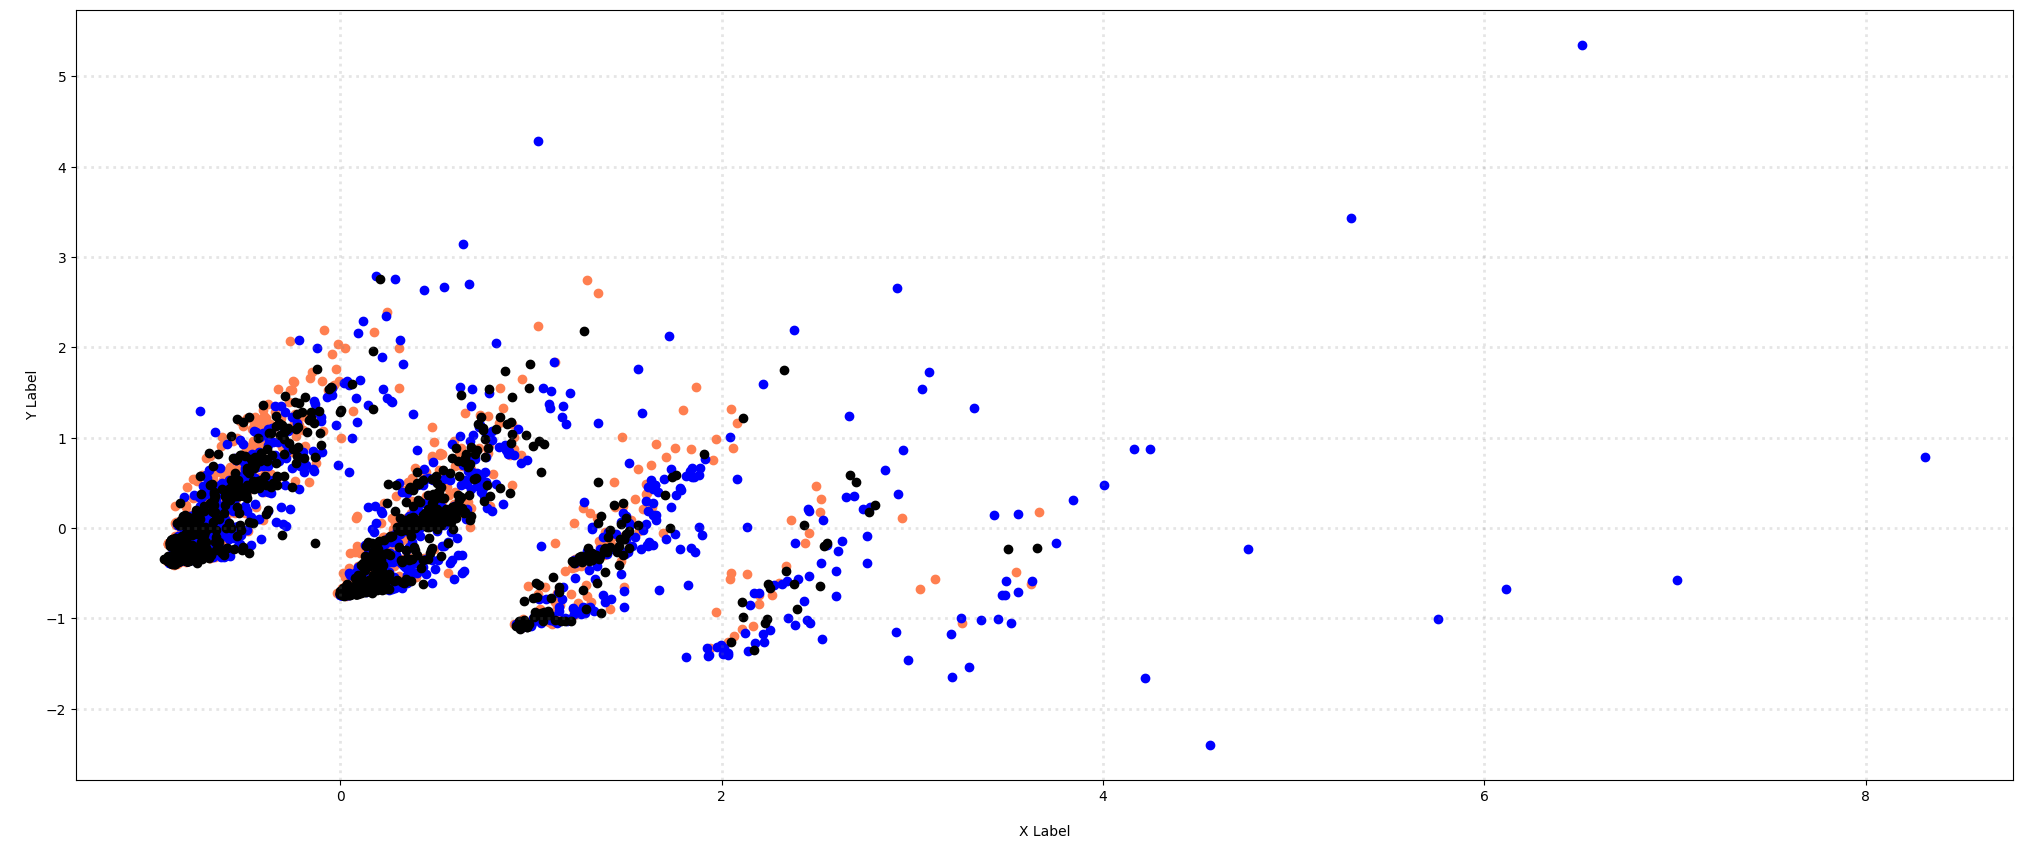

In [107]:
col = ['coral', 'blue', 'black']
import matplotlib.pyplot as plt
%matplotlib inline
# plot
fig = plt.figure(figsize = (25,10))
ax = fig.subplots()

for c, category in zip(col, categories):
    xs = X_reduced[X['category_name'] == category].T[0]
    ys = X_reduced[X['category_name'] == category].T[1]
   
    ax.scatter(xs, ys, c = c, marker='o')

ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.set_xlabel('\nX Label')
ax.set_ylabel('\nY Label')

plt.show()

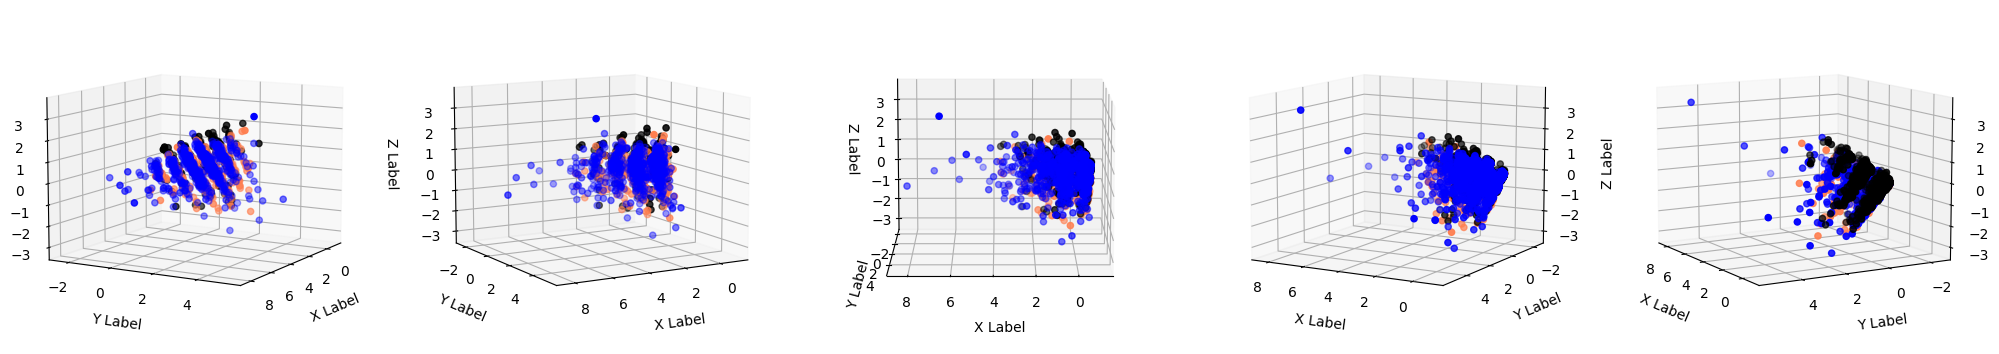

In [108]:
fig = plt.figure(figsize=(25,10))
X_reduced = PCA(n_components = 3).fit_transform(X_counts.toarray())

for i in range(1,6):
    #fig, axes = plt.subplots(1,3,i, projection = '3d')
    ax = fig.add_subplot(1,5,i, projection = '3d')
    #ax = plt.axes(projection = '3d')
    for c, category in zip(col, categories):
        xs = X_reduced[X['category_name'] == category].T[0]
        ys = X_reduced[X['category_name'] == category].T[1]
        zs = X_reduced[X['category_name'] == category].T[2]
        ax.scatter(xs, ys, zs, c = c, marker='o')
    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_xlabel('\nX Label')
    ax.set_ylabel('\nY Label')
    ax.set_zlabel('\nZ Label')
    ax.view_init(elev=10., azim=i*30)
plt.show()

In [109]:
df_X_count = pd.DataFrame(X_counts.toarray(), columns=count_vect.get_feature_names_out())
term_frequencies = df_X_count.sum()
import plotly.express as px 
fig = px.bar(x=term_frequencies.index[:300], y=term_frequencies[:300])
fig.show()
# need to zoom in to see all lable

In [110]:
def show_volc2(X_counts, cols):
    df_X_count = pd.DataFrame(X_counts.toarray(), columns=count_vect.get_feature_names_out())
    term_frequencies = df_X_count.sum().sort_values(ascending=False)
    fig = px.bar(x=term_frequencies.index[cols], y=term_frequencies[cols])
    fig.show()
# example
show_volc2(X_counts, slice(0, 30))

# Split data

In [124]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X['text'], X['label'], test_size=0.3, random_state=10)

# Gaussian Naive Bayes on tfidf

## Tfidf

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)



In [118]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
# tfidf + GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_tfidf.toarray(), y_train)
y_pred = gnb.predict(X_test_tfidf.toarray())
print("Number of mislabeled points out of a total %d points : %d using GaussianNB"
% (X_test_tfidf.shape[0], (y_test != y_pred).sum()))
# tfidf + BernoulliNB
bnb = BernoulliNB()
bnb.fit(X_train_tfidf.toarray(), y_train)
y_pred = bnb.predict(X_test_tfidf.toarray())
print("Number of mislabeled points out of a total %d points : %d using BernoulliNB"
% (X_test_tfidf.shape[0], (y_test != y_pred).sum()))


Number of mislabeled points out of a total 300 points : 86 using GaussianNB
Number of mislabeled points out of a total 300 points : 51 using BernoulliNB


### Comments
In this case we need to use BernoulliNB, since label is either 0 or 1.

And I tried, the BernoulliNB sure did better.


# Gaussian Naive Bayes on count

In [126]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [120]:
from sklearn.naive_bayes import BernoulliNB
# word frequency + BernoulliNB
bnb = BernoulliNB()
bnb.fit(X_train_cv.toarray(), y_train)
y_pred = bnb.predict(X_test_cv.toarray())
print("Number of mislabeled points out of a total %d points : %d"
% (X_test_cv.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 300 points : 51


### Comments
Simply use the counts as feature, results the same.